In [1]:
from datetime import datetime
import os
import re

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

from ipynb.fs.defs.functions import image_preprocess, train
from models.single_head_single_class.model import SingleHeadSingleClass

# Setup rng
torch.manual_seed(42)
np.random.seed(42)

In [2]:
model_type = SingleHeadSingleClass

In [3]:
# Check cuda is available and if so, set DEVICE to use gpu device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


In [4]:
# Load images and labels
data = pd.read_csv("data/unzipped/training_solutions_rev1.csv")

In [5]:
data.head()

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,...,0.000000,0.279952,0.138445,0.000000,0.000000,0.092886,0.0,0.0,0.0,0.325512
1,100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,...,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.0,0.0,0.0,0.000000
2,100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,100078,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,...,0.000000,0.094549,0.000000,0.094549,0.189098,0.000000,0.0,0.0,0.0,0.000000
4,100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


In [6]:
def label_preprocess(data: pd.Series):
    return np.array([data.iloc[1:4].to_numpy()]).astype(np.float32)

In [7]:
def prep_data(data: pd.DataFrame, test_size: float = 0.2, val_size: float = 0.5, number_of_galaxies: int = None):
    # Handle number of galaxies
    number_of_galaxies = len(data) if number_of_galaxies is None else number_of_galaxies

    def make_dataset(data: pd.DataFrame):
        labels = data.apply(lambda x: label_preprocess(x), axis=1)
        images = data["GalaxyID"].apply(lambda x: image_preprocess(x))

        input_data = torch.Tensor(np.stack(images.to_numpy())).permute(0, 3, 1, 2).to(DEVICE)
        output_data = torch.Tensor(np.stack(labels.to_numpy())).squeeze(1).to(DEVICE)

        dataset = torch.utils.data.TensorDataset(input_data, output_data)
        return dataset

    # Split data into train and test
    train_data, test_data = train_test_split(data.sample(number_of_galaxies), test_size=test_size)
    test_data, val_data = train_test_split(test_data, test_size=val_size)

    # Create training dataset
    train_dataset = make_dataset(train_data)

    # Create testing dataset
    test_dataset = make_dataset(test_data)

    # Create validation dataset
    val_dataset = make_dataset(val_data)

    return train_dataset, test_dataset, val_dataset

In [8]:
# Create train, test, and validation sets
train_dataset, test_dataset, val_dataset = prep_data(data)

In [9]:
print(
    f"Training input shape: {train_dataset.tensors[0].shape}\nTraining output shape: {train_dataset.tensors[1].shape}"
)

Training input shape: torch.Size([49262, 3, 64, 64])
Training output shape: torch.Size([49262, 3])


## Training

In [16]:
# Instantiate the model
model = model_type().to(DEVICE)

In [17]:
# Training Parameters
EPOCHS = 200
BATCH_SIZE = 64
LR = 0.001
GAMMA = 0.999

# Create a loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Competition requested MSE loss
optimizer = torch.optim.Adam(model.parameters(), lr=LR, betas=(0.9, 0.999))
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=GAMMA)

# Save path
model_name = "model"
save_path = "models/" + re.sub(r"(?<!^)(?=[A-Z])", "_", model.__class__.__name__).lower() + "/saved/"

In [18]:
print(f"Save path: {save_path}")

Save path: models/single_head_single_class/saved/


In [19]:
# Run a single image through the model
model_output = model(train_dataset.tensors[0][0].unsqueeze(0))
print(f"Model output shape: {model_output.shape}")

Model output shape: torch.Size([1, 3])


In [20]:
# Create a data loader for the training data
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Create a data loader for the test data
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [21]:
# Train the model
train_loss, test_loss = train(model, EPOCHS, train_loader, test_loader, optimizer, scheduler, criterion)

11/25 10:37:49 Train Epoch:    1 [49262/49262 (100%)]	Train Loss: 0.972283	Test Loss: 0.915927
11/25 10:37:53 Train Epoch:    2 [49262/49262 (100%)]	Train Loss: 0.907307	Test Loss: 0.900178
11/25 10:37:57 Train Epoch:    3 [49262/49262 (100%)]	Train Loss: 0.897082	Test Loss: 0.889736
11/25 10:38:01 Train Epoch:    4 [49262/49262 (100%)]	Train Loss: 0.891480	Test Loss: 0.884342
11/25 10:38:06 Train Epoch:    5 [49262/49262 (100%)]	Train Loss: 0.887000	Test Loss: 0.880869
11/25 10:38:10 Train Epoch:    6 [49262/49262 (100%)]	Train Loss: 0.883723	Test Loss: 0.877988
11/25 10:38:14 Train Epoch:    7 [49262/49262 (100%)]	Train Loss: 0.881294	Test Loss: 0.877671
11/25 10:38:18 Train Epoch:    8 [49262/49262 (100%)]	Train Loss: 0.879628	Test Loss: 0.879585
11/25 10:38:22 Train Epoch:    9 [49262/49262 (100%)]	Train Loss: 0.878140	Test Loss: 0.878421
11/25 10:38:26 Train Epoch:   10 [49262/49262 (100%)]	Train Loss: 0.877134	Test Loss: 0.879235
11/25 10:38:30 Train Epoch:   11 [49262/49262 (100

KeyboardInterrupt: 

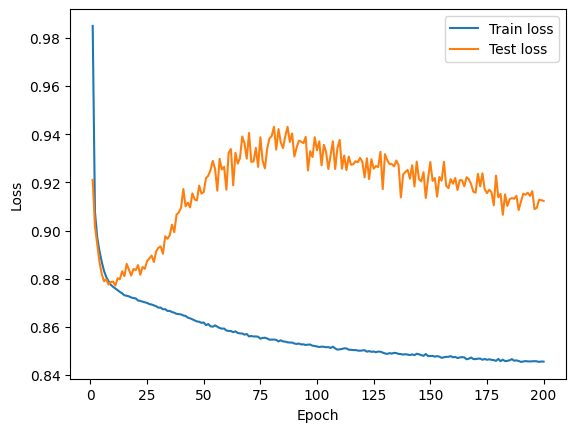

In [34]:
# Plot losses
plt.plot(range(1, EPOCHS + 1), train_loss, label="Train loss")
plt.plot(range(1, EPOCHS + 1), test_loss, label="Test loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

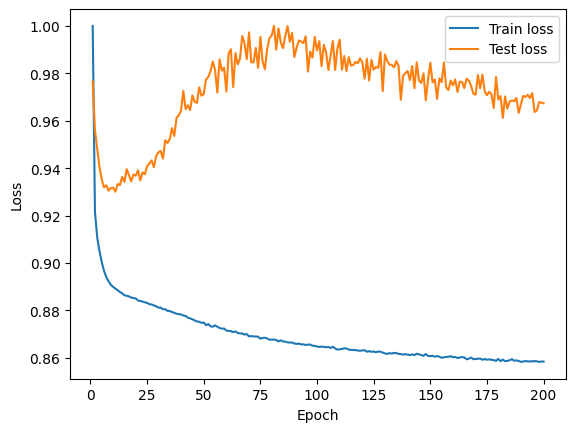

In [35]:
# Plot normalized losses
plt.plot(range(1, EPOCHS + 1), np.array(train_loss) / np.max(train_loss), label="Train loss")
plt.plot(range(1, EPOCHS + 1), np.array(test_loss) / np.max(test_loss), label="Test loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [36]:
# New model
if model_name is None:
    model_name = f"{datetime.now().strftime('%y%m%d%H%M%S')}_model_{model.__class__.__name__}_E{EPOCHS}_B{BATCH_SIZE}_LR{LR}_GAMMA{GAMMA}_TRAIN{train_loss[-1]:.4f}_TEST{test_loss[-1]:.4f}.pth"

In [37]:
# Save the model
if not os.path.exists(save_path):
    os.makedirs(save_path)
torch.save(model.state_dict(), save_path + model_name + ".pth")
print(f"Model saved as {model_name}")

Model saved as model


## Evaluation

In [38]:
# Load the model
model = model_type().to(DEVICE)
model.load_state_dict(torch.load(save_path + model_name + ".pth", weights_only=True, map_location=DEVICE))

<All keys matched successfully>

In [41]:
def break_out_solution(solutions):
    # Convert to numpy
    solutions = solutions.cpu().detach().numpy()

    # Columns 1-3 are class 1
    return [np.argmax(solutions[:, :3], axis=1)]

In [44]:
# Evaluation Metrics
model.eval()

# Eval Size
eval_size = 1000

# Create a data loader for the test data
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

true_labels = break_out_solution(val_dataset.tensors[1][:eval_size])
pred_labels = break_out_solution(model(val_dataset.tensors[0][:eval_size].to(DEVICE)))

# Calculate evaluation metrics
for i in range(len(true_labels)):
    print(f"Class {i + 1}:")
    print(f"Accuracy: {accuracy_score(true_labels[i], pred_labels[i])}")
    print(f"Precision: {precision_score(true_labels[i], pred_labels[i], average='macro')}")
    print(f"Recall: {recall_score(true_labels[i], pred_labels[i], average='macro')}")
    print(f"F1 Score: {f1_score(true_labels[i], pred_labels[i], average='macro')}")
    print()

TypeError: conv2d() received an invalid combination of arguments - got (TensorDataset, Parameter, NoneType, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias = None, tuple of ints stride = 1, tuple of ints padding = 0, tuple of ints dilation = 1, int groups = 1)
      didn't match because some of the arguments have invalid types: (!TensorDataset!, !Parameter!, !NoneType!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, !int!)
 * (Tensor input, Tensor weight, Tensor bias = None, tuple of ints stride = 1, str padding = "valid", tuple of ints dilation = 1, int groups = 1)
      didn't match because some of the arguments have invalid types: (!TensorDataset!, !Parameter!, !NoneType!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, !int!)


Class 1:


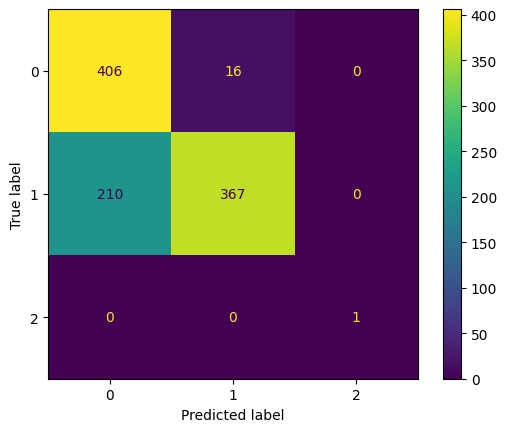


Class 2:


c:\Users\ethan\school\MSAAI\AAI 521\final_project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


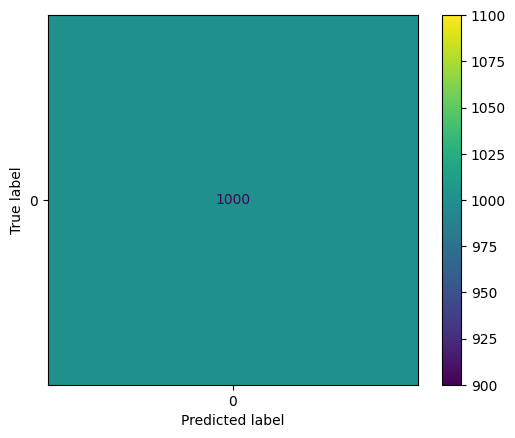


Class 3:


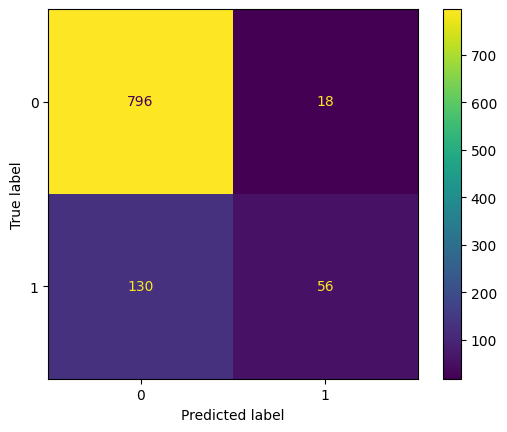


Class 4:


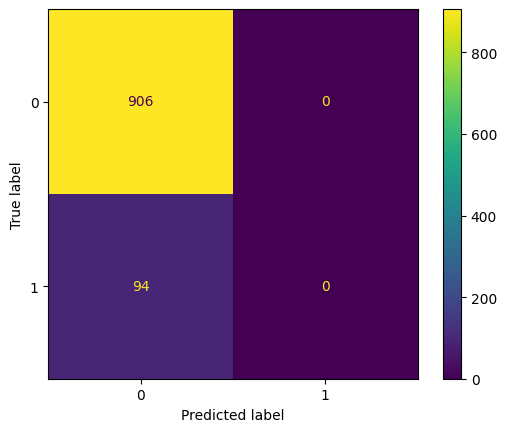


Class 5:


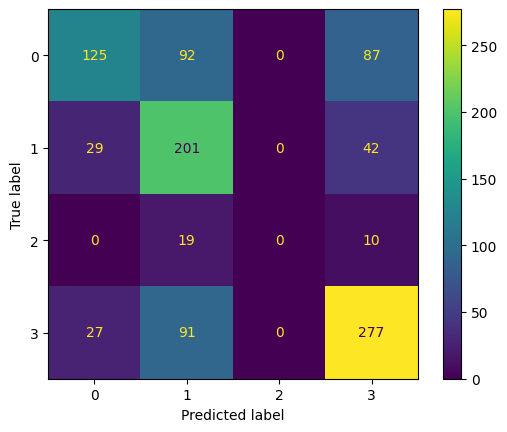


Class 6:


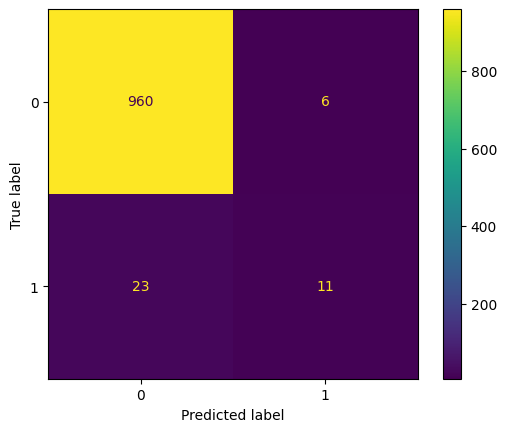


Class 7:


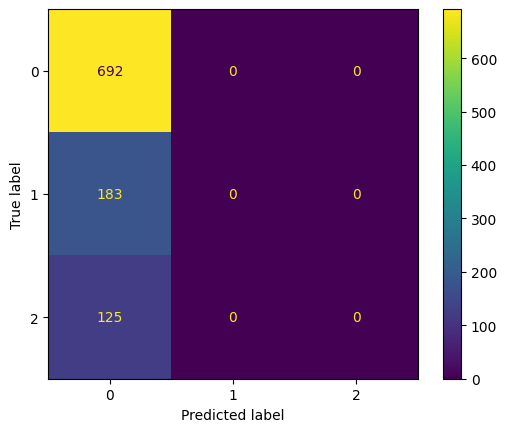


Class 8:


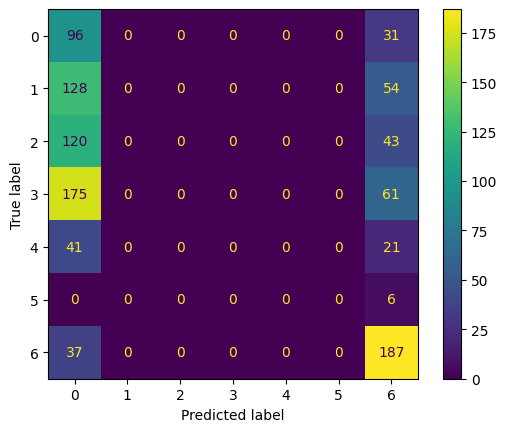


Class 9:


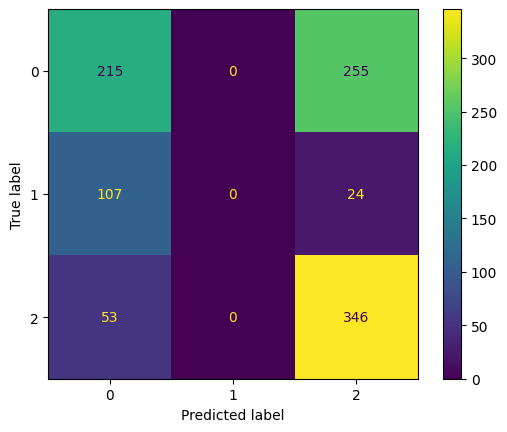


Class 10:


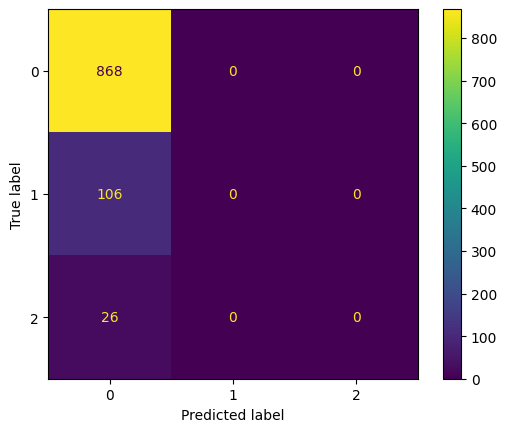


Class 11:


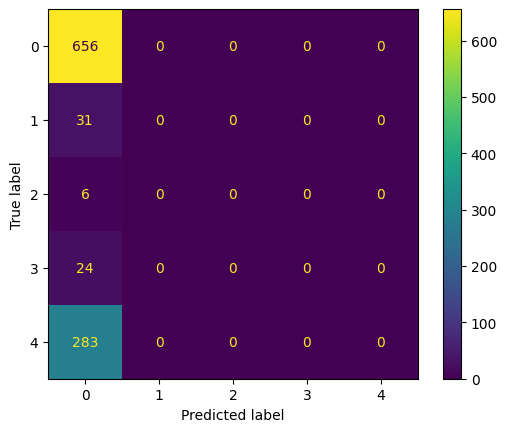

In [26]:
# Display confusion matrices in pretty format
for i in range(len(true_labels)):
    print(f"Class {i + 1}:")
    cm = confusion_matrix(true_labels[i], pred_labels[i])
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()
    plt.show()
    print()
